In [1]:
# I intend to extend the project to 2D, and make it easier to change the potentials

# Boundary Conditions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
from tqdm.auto import trange
from tqdm import tqdm

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setting Constants

#position boundaries
x_0 = 0
y_0 = 0
x_endpoints = np.linspace(-2, 2, 201)
y_endpoints = np.linspace(-2, 2, 201)

#time boundaries
t_i = 0
t_f = 8

#other constants
mass = 1
steps = 800
numb_paths = 1000

#array of times
times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]
print(x_endpoints)

[-2.   -1.98 -1.96 -1.94 -1.92 -1.9  -1.88 -1.86 -1.84 -1.82 -1.8  -1.78
 -1.76 -1.74 -1.72 -1.7  -1.68 -1.66 -1.64 -1.62 -1.6  -1.58 -1.56 -1.54
 -1.52 -1.5  -1.48 -1.46 -1.44 -1.42 -1.4  -1.38 -1.36 -1.34 -1.32 -1.3
 -1.28 -1.26 -1.24 -1.22 -1.2  -1.18 -1.16 -1.14 -1.12 -1.1  -1.08 -1.06
 -1.04 -1.02 -1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82
 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58
 -0.56 -0.54 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34
 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1
 -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14
  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38
  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86
  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1
  1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26  1.28

# Functions

In [4]:
#Creating the position generating function

def Pos_Gen(x0, xN, Steps, dt):
    path = np.zeros(Steps)
    path[0] = x0

    for i in range(1, Steps):
        path[i] = path[i-1] + np.random.normal(0, np.sqrt(dt))

    # shift so endpoint is exactly xN
    path += np.linspace(0, xN - path[-1], Steps)
    return path

In [5]:
#Creating function to evaluate the action integral for a path

def action_harmonic(positions, times, mass, potential):
    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        dx = positions[i + 1] - positions[i]
        T = 0.5 * mass * (dx / dt) ** 2

        x_mid = (positions[i] + positions[i+1])/2
        V = potential(x_mid)

        S += dt * (T + V)

    return S



In [6]:
# defining the x and y potentials

def x_potential(x):
    return 0.5 * x ** 2

def x_potential_eff(x, dt, m=1):
    return 0.5*x**2 + (dt**2 / (24*m)) * x**2

def y_potential(y):
    return 0.25*(y**2-1)**2
    # if np.abs(y) < 1:
    #     return 0
    # if np.abs(y) > 1:
    #     return 1e26



In [18]:
def metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop):
    """
    Vectorised Metropolis update for interior points of all paths.
    Includes kinetic + potential terms.

    paths: (n_paths, n_steps) array
    i: index of the interior point to update (1 <= i <= n_steps-2)
    sigma_prop: standard deviation of symmetric proposal distribution
    """
    dt = times[1] - times[0]

    x_old = paths[:, i]
    x_prev = paths[:, i - 1]
    x_next = paths[:, i + 1]

    # Symmetric Gaussian proposal
    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change
    dS_kin = (mass / (2*dt)) * (
    (x_new - x_prev)**2 + (x_next - x_new)**2
  - (x_old - x_prev)**2 - (x_next - x_old)**2)



    # Potential term change
    x_mid_prev_old = 0.5 * (x_prev + x_old)
    x_mid_next_old = 0.5 * (x_old + x_next)
    x_mid_prev_new = 0.5 * (x_prev + x_new)
    x_mid_next_new = 0.5 * (x_new + x_next)
    dS_pot = dt * (
    potential(x_mid_prev_new) + potential(x_mid_next_new)
  - potential(x_mid_prev_old) - potential(x_mid_next_old)
    )


    # Total action change
    dS = dS_kin + dS_pot

    # Metropolis accept/reject
    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)  # return acceptance fraction for diagnostics

In [19]:
def metropolis_endpoint_update_vectorised(paths, times, mass, potential, sigma_prop):
    """
    Vectorised Metropolis update for endpoint (last point) of all paths.
    """
    dt = times[1] - times[0]
    i = paths.shape[1] - 1  # last point

    x_old = paths[:, i]
    x_prev = paths[:, i-1]

    # symmetric proposal
    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change (only one neighbor)
    dS_kin = (mass / (2*dt)) * ((x_new - x_prev)**2 - (x_old - x_prev)**2)

    # Potential at midpoint between second-to-last and endpoint
    x_mid_old = 0.5 * (x_prev + x_old)
    x_mid_new = 0.5 * (x_prev + x_new)
    dS_pot_mid = dt * (potential(x_mid_new) - potential(x_mid_old))

    # CRITICAL FIX: Also include potential at the endpoint itself (half weight)
    dS_pot_end = 0.5 * dt * (potential(x_new) - potential(x_old))

    dS = dS_kin + dS_pot_mid + dS_pot_end

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

In [20]:
def metropolis_sweep_vectorised(paths, times, mass, potential, sigma_prop):
    n_steps = paths.shape[1]
    acceptances = np.zeros(n_steps - 2)

    # Update interior points
    for i in range(1, n_steps - 1):
        acceptances[i - 1] = metropolis_path_update_vectorised(
            paths, times, mass, potential, i, sigma_prop
        )

    # Update endpoint
    endpoint_accept = metropolis_endpoint_update_vectorised(
        paths, times, mass, potential, sigma_prop
    )

    return acceptances, endpoint_accept

# X- Dimension

Thermalizing...


Thermalising:   0%|          | 2/500 [00:00<00:42, 11.63it/s]

Midpoint acceptance ≈ 0.318, Endpoint acceptance ≈ 0.445


Thermalising:  21%|██        | 103/500 [00:08<00:33, 11.83it/s]

Midpoint acceptance ≈ 0.315, Endpoint acceptance ≈ 0.426


Thermalising:  41%|████      | 203/500 [00:17<00:25, 11.88it/s]

Midpoint acceptance ≈ 0.336, Endpoint acceptance ≈ 0.452


Thermalising:  61%|██████    | 303/500 [00:25<00:16, 11.87it/s]

Midpoint acceptance ≈ 0.363, Endpoint acceptance ≈ 0.436


Thermalising:  81%|████████  | 403/500 [00:33<00:08, 11.82it/s]

Midpoint acceptance ≈ 0.330, Endpoint acceptance ≈ 0.438


Thermalising: 100%|██████████| 500/500 [00:42<00:00, 11.86it/s]


Endpoint standard deviation: 0.4844
Sample endpoint values: [-0.85495956 -0.47813336  0.39352408 -0.23371134  0.13616269]

Sampling...


Sampling: 100%|██████████| 5000/5000 [07:00<00:00, 11.88it/s]


Endpoint std: 0.7101

------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.7101 (expected ≈ 0.707)
Root mean square: 0.7101 (expected ≈ 0.707)


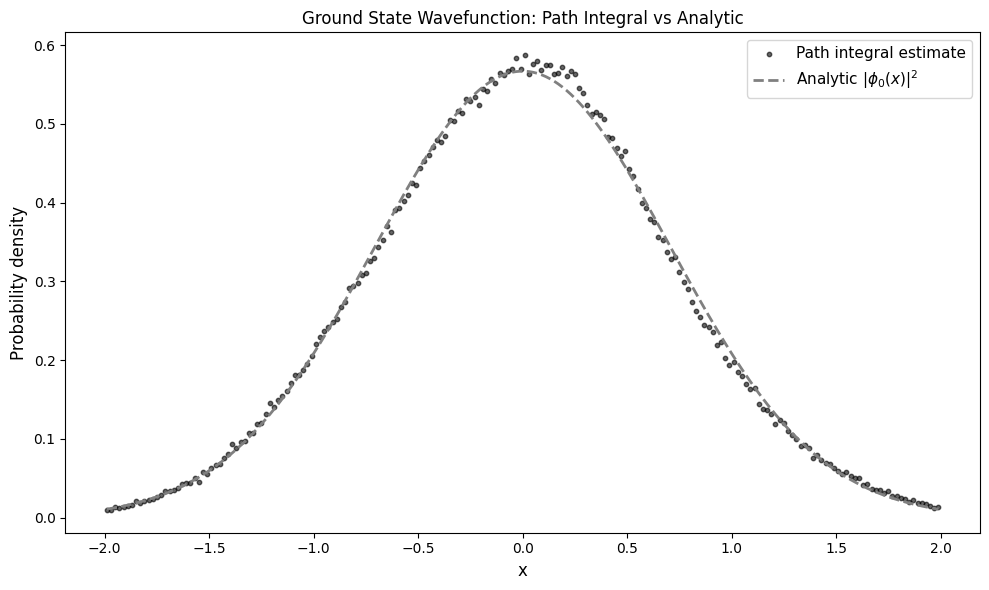

In [25]:
# Initialise paths (Brownian bridge)
paths_x = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5

mid = paths_x.shape[1] // 2  # midpoint of the path
thin = 10                     # only record 1 sample every 'thin' sweeps
sigma_prop = C*np.sqrt(dt)          # proposal step, tune to get midpoint acceptance ~0.3-0.5
sigma_endpoint = sigma_prop/np.sqrt(2)

# -----------------------------
# Thermalisation
# -----------------------------
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Midpoint acceptance ≈ {acceptances[mid-1]:.3f}, "
                   f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

print(f"Endpoint standard deviation: {np.std(paths_x[:, -1]):.4f}")
print(f"Sample endpoint values: {paths_x[:5, -1]}")
# -----------------------------
# Sampling
# -----------------------------
print("\nSampling...")
# After sampling, check ENDPOINT distribution instead of midpoint
endpoint_samples = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % thin == 0:
        endpoint_samples.append(paths_x[:, -1].copy())  # ENDPOINT not midpoint

endpoint_samples = np.concatenate(endpoint_samples)
print(f"Endpoint std: {np.std(endpoint_samples):.4f}")

samples = endpoint_samples

# -----------------------------
# Measure ground-state PDF
# -----------------------------
# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic /= np.sum(phi_sq_analytic * dx)

# Statistics
mean_square = np.mean(samples**2)
rms = np.sqrt(mean_square)
std = np.std(samples)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color = "black")
plt.plot(x_centres, phi_sq_analytic, 'grey',linestyle = "--", linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')
plt.tight_layout()
plt.show()